## Analyze A/B Test for E-commerce Website 

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)



<a id='intro'></a>
### Introduction
A/B test run for an e-commerce website. Goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

In [18]:
#To get started, import libraries.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp']) 

In [16]:
df.sort_values(by=['timestamp'])

,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0
...,...,...,...,...,...
153305,851645,2017-01-24 13:41:18.869978,treatment,old_page,0
47535,808330,2017-01-24 13:41:19.152664,control,old_page,0
157787,843121,2017-01-24 13:41:44.097174,treatment,new_page,0
179072,836373,2017-01-24 13:41:52.604673,control,old_page,0


_`The test runs from 2/1/2017 to 24/1/2017. Therefore, the test runs for 23 days.`_

b. Use the below cell to find the number of rows in the dataset.

In [49]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [50]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [51]:
df.converted.mean()*100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [52]:
a = df.query('group == "treatment" and landing_page != "new_page"')
b = df.query('group != "treatment" and landing_page == "new_page"')
a.shape[0] + b.shape[0]

3893

f. Do any of the rows have missing values?

In [53]:
df.isna().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [54]:
df2 = df #copy original dataframe to new one
incorrect = a.append(b) #combine incorrect rows
incorrect_index = incorrect.index #identify index of incorrect rows
df2 = df2.drop(incorrect_index) #drops incorrect rows

In [55]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions.

a. How many unique **user_id**s are in **df2**?

In [56]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [57]:
sum(df2.user_id.duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [58]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [59]:
# save the duplicated row index
ind = df2[df2.duplicated('user_id')].index
df2 = df2.drop(ind)

# Double Check of row was removed - this should be False
df2.user_id.duplicated().values.any()

False

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [60]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [61]:
df2.query('group == "control" and converted == 1').shape[0]/df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [62]:
df2.query('group == "treatment" and converted == 1').shape[0]/df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [63]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

_`The control group converted rate is slightly higher than the treatment group. However, the differs unable to state evidence to make a decision.`_ <br><br>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


$H_{0}$:  $p_{old}$ ≥ $p_{new}$  

 $H_{1}$:  $p_{old}$ < $p_{new}$
 <br><br>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [64]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [65]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [66]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [67]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [68]:
new_page_converted = np.random.choice([1, 0], n_new, p = [p_new, (1-p_new)])
new_page_converted.mean()

0.11990227788865185

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [69]:
old_page_converted = np.random.choice([1, 0], n_old, p = [p_old, (1-p_old)])
old_page_converted.mean()

0.12039318804466044

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [70]:
new_page_converted.mean() - old_page_converted.mean()

-0.0004909101560085921

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [90]:
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted 

In [72]:
# convert to numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [73]:
treatment_converted_mean = df2.query('group == "treatment"')['converted'].mean()
control_converted_mean = df2.query('group == "control"')['converted'].mean()
actual_diff = treatment_converted_mean - control_converted_mean
actual_diff

-0.0015782389853555567

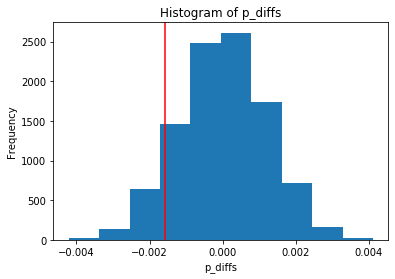

In [74]:
plt.hist(p_diffs);
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Histogram of p_diffs');
plt.axvline(actual_diff, c ='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [75]:
# Compute p value
(p_diffs > actual_diff).mean()

0.9036

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

_`In j computed p value which is 0.9065, couldn't reach a significant result led to fail to reject null hypothesis.`_ <br><br>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [76]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted == 1)) 
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1))
n_old = sum(df2.group == 'control')
n_new = sum(df2.group == 'treatment')

print("convert_old:", convert_old) 
print("convert_new:", convert_new)
print("n_old:", n_old)
print("n_new:", n_new)

convert_old: 17489
convert_new: 17264
n_old: 145274
n_new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [77]:
z_score, p_value = sm.stats.proportions_ztest(count = [convert_new, convert_old], nobs = [n_new, n_old], alternative = 'larger')
print("z-score: ", z_score, "p-value: ", p_value)

z-score:  -1.3109241984234394 p-value:  0.9050583127590245


In [78]:
from scipy.stats import norm

norm.ppf(.975)
# 1.96 Tells the critical value at 95% of confidence

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

_`P-value is 0.9 which agrees with the finiding in j, z-test is 1.31 does not exceed the critical value of 1.96, so based on the test lead to the same result found before fail to reject null hypothesis`_ <br><br>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

_`Logistic regression`_

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [79]:
df2['intercept'] = 1
df2[['nothing','ab_page']] = pd.get_dummies(df2['group'])
df2.drop('nothing', axis =1, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


`
First row in the dataframe was control so get_dummies will assign a reverse 
of what has been asked, by adding new column 'nothing' to meet the required 
from the question: when group is treatment ab_page is 1 and 0 if control.
`<br><br>

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [80]:
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [81]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        16:50:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

_`P-value is 0.19 which less than 0.9 in partII (0.9) however still higher than type I error (0.05). it is not statistically significant to predit a conversion. 
null and alternative hypotheses is follows with logistic regression model:`_

$H_{0}$:  $p_{new}$ - $p_{old}$ = 0  

 $H_{1}$:  $p_{new}$ - $p_{old}$ ≠ 0

_`so this is "equal or not" rather than "larger or not" which did in part I and part II`_
<br><br>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

_`Adding more factors may influence people to convert. However,  many factors will give a misleading result. The performance of the regression model might not enhance. The best practice is to get a minimum number of attributes to tell the maximum information needed.`_ <br><br>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.

Does it appear that country had an impact on conversion?

In [82]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [83]:
### Create the necessary dummy variables
dummy = pd.get_dummies(data = countries_df, columns = ['country'])
df3 = dummy.merge(df2, on = 'user_id')
df3.head()

,user_id,country_CA,country_UK,country_US,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [84]:
logit_2 = sm.Logit(df3['converted'], df3[['country_CA', 'country_US', 'intercept']])
result_2 = logit_2.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [85]:
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        16:50:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
country_CA    -0.0507      0.028     -1.786      0.074      -0.106       0.005
country_US    -0.0099      0.013     -0.746      0.456      -0.036       0.016
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
==============================================================================
"""

_`P-values of countries is grater than 0.05. However countries doesn't explain the conversion rate.`_ <br><br>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [86]:
df3['US_new'] = df3['country_US'] * df3['ab_page']
df3['CA_new'] = df3['country_CA'] * df3['ab_page']

In [87]:
# Fit Linear Model And Obtain the Results
logit_3 = sm.Logit(df3['converted'], df3[['intercept','country_CA', 'country_US', 'US_new', 'CA_new']])
result_3 = logit_3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [88]:
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 05 Jul 2020   Pseudo R-squ.:               3.376e-05
Time:                        16:50:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1265
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
country_CA    -0.0172      0.038     -0.450      0.652      -0.092       0.058
country_US     0.0003      0.015      0.022      0.982      -0.029       0.030
US_new        -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA_new        -0.0674      0.052     -1.297      0.195      -0.169       0.034
==============================================================================
"""

_`The above logit regression results show only intercept's p-value is less than type I error (0.05) while other variables higher than 0.05.
`_ <br><br>

<a id='conclusions'></a>
## Conclusions

_`The Test conditions and the amount of data were suitable for the analysis, with no missing or few inconsistent data. The test runs for 23 days. The users have an equal chance to try the old or the new page, so both of the groups had a similar size.`_

_`In conclusion, no evidence would make the new page work better than the old page as a result fail to reject the null hypothesis. Moreover, there is a chance the old page performs better due to user resistance to change. The countries have roughly similar results. Therefore, couldn't use the countries to predict user preferences.`_

_`The next steps could be to include other factors to the model to find out reasons that make the new page performed poorly. I would recommend keeping improving the new page before making another test.`_
<br><br>

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_Results'])

4294967295